In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files

In [20]:
drive.mount('/content/drive')

# Read CSV
df = pd.read_csv('/content/poems-100.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
df.head()

,text
0,"O my Luve's like a red, red rose\nThat’s newly..."
1,"The rose is red,\nThe violet's blue,\nSugar is..."
2,How do I love thee? Let me count the ways.\nI ...
3,"Had I the heavens' embroidered cloths,\nEnwrou..."
4,"I.\n Enough! we're tired, my heart and I.\n..."


In [22]:

# Extract only the poems content
poems = df['text'].dropna().tolist()

# Convert to lowercase and remove special characters
cleaned_poems = [re.sub(r"[^a-zA-Z\s]", "", poem.lower()) for poem in poems]

In [23]:
# Tokenization
all_words = [word for poem in cleaned_poems for word in poem.split()]
vocab = sorted(set(all_words))
vocab_size = len(vocab)
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}


In [24]:
# Prepare dataset
seq_length = 2
input_data = []
target_data = []
for poem in cleaned_poems:
    words = poem.split()
    for i in range(len(words) - seq_length):
        input_data.append([word_to_idx[words[j]] for j in range(i, i+seq_length)])
        target_data.append(word_to_idx[words[i + seq_length]])

X = torch.tensor(input_data, dtype=torch.long)
y = torch.tensor(target_data, dtype=torch.long)

In [25]:
# Define LSTM Model with Embeddings
class LSTMWithEmbeddings(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMWithEmbeddings, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [26]:
# Initialize model
embed_size = 16
hidden_size = 16
model = LSTMWithEmbeddings(vocab_size, embed_size, hidden_size, vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [27]:
# Training loop
epochs = 500
losses = []
accuracies = []

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Compute accuracy
    _, predicted = torch.max(output, 1)
    accuracy = (predicted == y).float().mean().item()
    accuracies.append(accuracy)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch 100/500, Loss: 5.3216, Accuracy: 0.1097
Epoch 200/500, Loss: 3.9247, Accuracy: 0.2603
Epoch 300/500, Loss: 3.1576, Accuracy: 0.3916
Epoch 400/500, Loss: 2.7787, Accuracy: 0.4549
Epoch 500/500, Loss: 2.5610, Accuracy: 0.4903


In [28]:
# Save model weights
torch.save(model.state_dict(), "lstm_embeddings_weights.pth")
print("Model weights saved as lstm_embeddings_weights.pth")

Model weights saved as lstm_embeddings_weights.pth


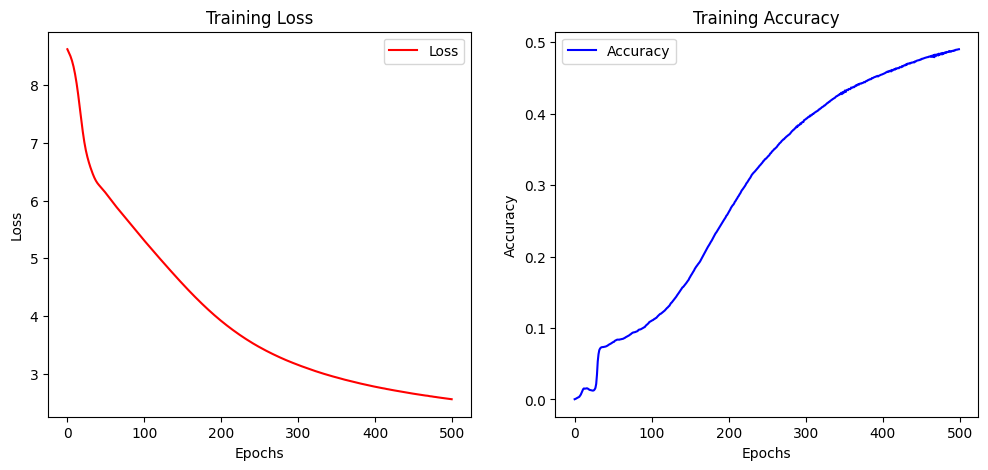

In [29]:
# Plot Loss and Accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [30]:
# Generate text
def generate_text(start_word, length=5):
    model.eval()
    words = [start_word]
    for _ in range(length):
        input_seq = torch.tensor([[word_to_idx[words[-1]]]], dtype=torch.long)
        with torch.no_grad():
            output = model(input_seq)
            next_word = idx_to_word[torch.argmax(output).item()]
        words.append(next_word)
    return ' '.join(words)

print("Generated Text:", generate_text("love"))

Generated Text: love too and shade space outside
